<a href="https://colab.research.google.com/github/SIVASKANDAN-P/GESTURE_RECOGNITION/blob/main/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
pip install Pillow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
from imageio import imread
from PIL import Image
#from scipy.ndimage import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/gesture recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/gesture recognition/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [6]:
img_idx = [i for i in range(0,31,2)]
print(img_idx)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


In [7]:
train_doc.size

663

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
from skimage.transform import resize


In [10]:
def cropResize(image, y, z):
    h, w = image.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))


In [11]:
def normalizeImage(image):
    # applying normalization
    return image/255.0


In [12]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))


In [13]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30,2)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        #print(len(t))
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('idx',idx)
                    #print('batch',batch)
                    #print(num_batches)
                    #print('size',batch_size)
                    ##print('item',item)
                    #print('len',len(imgs))
                    #print(t[folder + (batch*batch_size)])
                    #print(imgs[item])
                    image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    y=120
                    z=120
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print(len(batch_data))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        #batch = batch + 1
        if (len(folder_list)%batch_size > 0):
          batch = batch + 1
          #print('in extra')
          #print('batch',batch)
          #print('num_batches',num_batches)
          #print(int(len(folder_list)%batch_size))
          batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(int(len(folder_list)%batch_size)): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          print(len(batch_data))
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [24]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [14]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = '/content/drive/MyDrive/gesture recognition/Project_data/train'
val_path = '/content/drive/MyDrive/gesture recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


In [15]:
# Traversing through Test
import os

# List to store all empty
# directories
empty = []

for root, dirs, files in os.walk('/content/drive/MyDrive/gesture recognition/Project_data/train'):

    # Checking the size of tuple
    if not len(dirs) and not len(files):

        # Adding the empty directory to
        # list
        empty.append(root)

print("Empty Directories:")
print(len(empty))


Empty Directories:
0


In [16]:
print(len(train_doc))

663


In [16]:
#train = generator(train_path, train_doc, 100)
#data,label = next(train)

In [ ]:
#data,label = next(train)

<ipython-input-124-9c6694632e00>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
#data,label = next(train)

<ipython-input-124-9c6694632e00>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
data,label = next(train)

<ipython-input-124-9c6694632e00>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
#data,label = next(train)

<ipython-input-124-9c6694632e00>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
#data,label = next(train)

<ipython-input-124-9c6694632e00>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
#data,label = next(train)

in extra
batch 6
num_batches 6
63


<ipython-input-124-9c6694632e00>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


100


In [ ]:
#print(label)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
#?layers.Conv2D

Object `layers.Conv2D` not found.


In [17]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

print(make3dFilter(5))

(5, 5, 5)


Experiment 1 : Basic model.

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
inputShape = (15, 120, 120, 3)

model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
])
#model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#model.summary()





Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [19]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 11, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 58, 58, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 28, 28, 32)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [29]:
exp1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-29-da80cae902a7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  exp1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-13-37504fb0bfd8>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
65/67 [============================>.] - ETA: 2s - loss: 0.8373 - categorical_accuracy: 0.6862

<ipython-input-13-37504fb0bfd8>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path  +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


10
67/67 [==============================] - ETA: 0s - loss: 0.8373 - categorical_accuracy: 0.6776
Epoch 1: saving model to model_init_2023-09-0208_39_37.183022/model-00001-0.83726-0.67761-4.74019-0.23000.h5
67/67 [==============================] - 86s 1s/step - loss: 0.8373 - categorical_accuracy: 0.6776 - val_loss: 4.7402 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 0.8054 - categorical_accuracy: 0.6940
Epoch 2: saving model to model_init_2023-09-0208_39_37.183022/model-00002-0.80536-0.69403-16.22771-0.27000.h5
67/67 [==============================] - 83s 1s/step - loss: 0.8054 - categorical_accuracy: 0.6940 - val_loss: 16.2277 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.8675 - categorical_accuracy: 0.6478
Epoch 3: saving model to model_init_2023-09-0208_39_37.183022/model-00003-0.86748-0.64776-2.28642-0.33000.h5
67/67 [========================

In [30]:
import matplotlib.pyplot as plt

def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

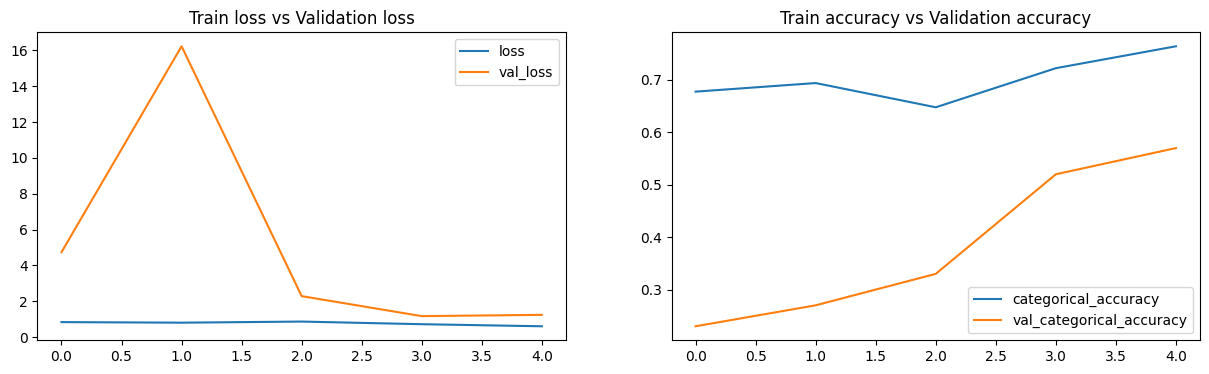

Max. Training Accuracy 0.7641791105270386
Max. Validaiton Accuracy 0.5699999928474426


In [31]:
plotModelHistory(exp1)

Experiment 2